## physics4481-7681/cs4812 ps3 problem 1
### due Fri 15 Oct 23:00 via gradescope

This is the first problem of ps3 -- the remaining problems are [here](https://courses.cit.cornell.edu/physics4481-7681_2021fa/ps3.pdf)

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Loading your IBM Quantum account(s)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
#provider = IBMQ.get_provider(hub='ibm-q-education', group='cornell-uni-2', project='physics-4481')

In this problem, you will run the Deutsch-Jozsa algorithm on a real quantum computer. The exercise is based on [this](https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html) chapter of the Qiskit textbook. First, read through that chapter until you feel like you understand the algorithm and how we are going to implement it on a real quantum device.

For our implementation, we will pick $n=3$, i.e. the function $f(x)$ will take a 3-bit bit string to a 1-bit output. In order to implement the balanced quantum oracles shown in Section 3 of the textbook chapter, we need to apply CNOT gates between each of the 3 qubits in the upper register and the 1 qubit in the lower register. Take a look at the 5-qubit devices that you can access. You should find some where a single qubit is connected to 3 other qubits. Fill in the information below:

In [15]:
n = 3
device_name = 'ibmq_belem' # e.g. 'ibmq_bogota'
qubits = [0, 2, 3, 1]# fill in with a list [x0, x1, x2, y], where y is the number of the qubit that is directly connected to x0, x1, and x2.

Next, copy the functions `dj_oracle` and `dj_algorithm` from the textbook chapter to the following cell. Make sure you understand every line in these functions.

In [16]:
#copy dj_oracle and dj_algorithm from the qiskit textbook
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate


def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

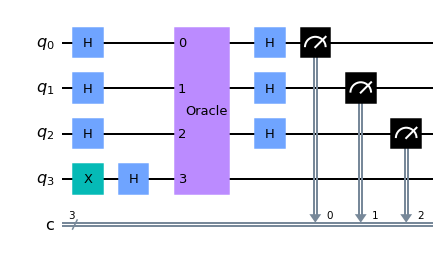

In [17]:
dj_circuit = QuantumCircuit(n+1, n)
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

Next, let's set up an experiment to test the performance of this algorithm. Let's randomly pick oracles that are either balanced or constant feed them into the Deutsch-Jozsa algorithm, and run this on a real quantum computer. We will find the fraction of the time that we can correctly determine whether the function was constant or balanced using a single function call. Classically, we can't know which it was from a single function call, so if we succeed more than 50% of the time, then we have beat the classical algorithm.

As in the previous homework, we will run 75 circuits, each with one shot.

In [18]:
max_circuits = 75
shots = 1

Generate a numpy array of length `max_circuits` where each element is either 0 or 1, randomly chosen with equal probability. Let's pick the convention that 0 corresponds to constant and 1 corresponds to balanced.

In [19]:
balanced_or_constant = np.random.randint(2, size = max_circuits)
balanced_or_constant

array([1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1])

Now, using the previous homework as a template, perform the experiment described above. Submit all 75 circuits in a single job. Perform a hypothesis test to check whether you are beating the classical win-rate (50%).

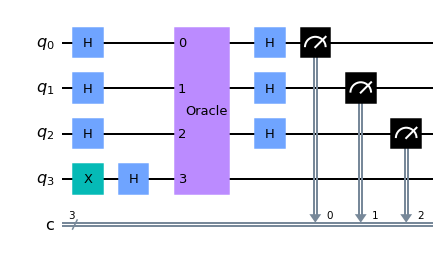

In [20]:
# get all 75 circuits
qc_all = []
for i in range(max_circuits):
    if balanced_or_constant[i] == 0 :
        case = 'constant'
    else:
        case = 'balanced'
    dj_circuit = QuantumCircuit(n+1, n)
    oracle_gate = dj_oracle(case, n)
    dj_circuit = dj_algorithm(oracle_gate, n)
    qc_all.append(dj_circuit)

qc_all[0].draw('mpl')

In [21]:
# submit all 75 circuits in a single job 
from qiskit import IBMQ, execute
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.backend.backends(device_name)[0] # the backend is the quantum computer that you picked.
tags = ['Deutsch-Jozsa', f'x = {list(balanced_or_constant)}'] # set some tags to describe the experiment.
job = execute(qc_all, backend, shots = 1)
counts = job.result().get_counts() # this returns list of dictionaries of the results for each circuit we executed.

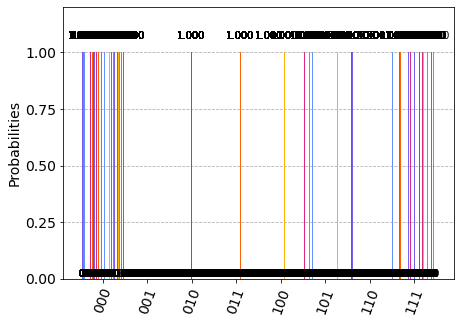

In [22]:
# plot the results before computation
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [31]:
results = np.array([list(c) for c in counts]).flatten()
print('results', results)
correct = 0
for i in range(len(balanced_or_constant)):
    if (results[i] == '111' or results[i] == '000') and balanced_or_constant[i] == 0:
        correct += 1
    elif (results[i] != '111' and results[i] != '000') and balanced_or_constant[i] == 1:
        correct += 1
print('Winning probability', correct/len(results), '%')

results ['111' '101' '000' '000' '000' '000' '110' '110' '000' '001' '101' '111'
 '111' '111' '111' '101' '000' '100' '000' '000' '000' '000' '000' '000'
 '110' '000' '000' '111' '111' '000' '111' '111' '000' '101' '000' '000'
 '010' '111' '111' '000' '000' '110' '111' '100' '011' '101' '111' '000'
 '000' '000' '101' '111' '000' '111' '000' '000' '000' '000' '101' '111'
 '111' '000' '000' '000' '000' '000' '000' '111' '000' '000' '111' '000'
 '000' '000' '111']
Winning probability 0.7066666666666667 %


In [35]:
# perform a hypothesis test
#compute the number of time 
import scipy.stats as stats
p_classical = .5
result = stats.binomtest(correct, len(results), p_classical, alternative = 'greater')
print("Binomial test: p-value of the hypothesis", result.pvalue)
if result.pvalue > .05:
    print('The null hypothesis is valid. The Deutsch-Jozsa algorithm cannot beat the classical winnig limit 75%.')
else:
    print("The null hypothesis is rejected, and the alternatice hypothesis is valid.\n The Deutsch-Jozsa algorithm can beat the calssical winnig limit 50%!")



Binomial test: p-value of the hypothesis 0.00022482398582190612
The null hypothesis is rejected, and the alternatice hypothesis is valid.
 The Deutsch-Jozsa algorithm can beat the calssical winnig limit 50%!
